# 🛰️Predicting the Hubble Parameter and the Age of the Universe using Supernovae Ia Data
### AUMANSH VIJAYENDRA GUPTA
### aumansh.gupta119560@marwadiuniversity.ac.in
In this assignment, we will analyze observational data from the Pantheon+SH0ES dataset of Type Ia supernovae to measure the Hubble constant $H_0$ and estimate the age of the universe. We will:

- Plot the Hubble diagram (distance modulus vs. redshift)
- Fit a cosmological model to derive $H_0$ and $\Omega_m$
- Estimate the age of the universe
- Analyze residuals to assess the model
- Explore the effect of fixing $\Omega_m$
- Compare low-z and high-z results

Let's get started!


### 📦 Getting Started: Setup and Libraries:

Before we dive into the analysis, we need to import the necessary Python libraries:

- `numpy`, `pandas` — for numerical operations and data handling
- `matplotlib` — for plotting graphs
- `scipy.optimize.curve_fit` and `scipy.integrate.quad` — for fitting cosmological models and integrating equations
- `astropy.constants` and `astropy.units` — for physical constants and unit conversions


In [ ]:
 import numpy as np
 import pandas as pd
 import matplotlib.pyplot as plt
 from scipy.optimize import curve_fit
 from scipy.integrate import quad
 from astropy.constants import c
 from astropy import units as u
 from IPython.display import Image, display

### 📂 Load the Pantheon+SH0ES Dataset:

We now load the observational supernova data from the Pantheon+SH0ES sample. This dataset includes calibrated distance moduli $\mu$, redshifts corrected for various effects, and uncertainties.

### Instructions:
- Make sure the data file is downloaded from [Pantheon dataset](https://github.com/PantheonPlusSH0ES/DataRelease/blob/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES.dat) and available locally.
- We use `delim_whitespace=True` because the file is space-delimited rather than comma-separated.
- Commented rows (starting with `#`) are automatically skipped.

### We will extract:
- `zHD`: Hubble diagram redshift
- `MU_SH0ES`: Distance modulus using SH0ES calibration
- `MU_SH0ES_ERR_DIAG`: Associated uncertainty


#### More detailed column names and the meanings can be referred here:



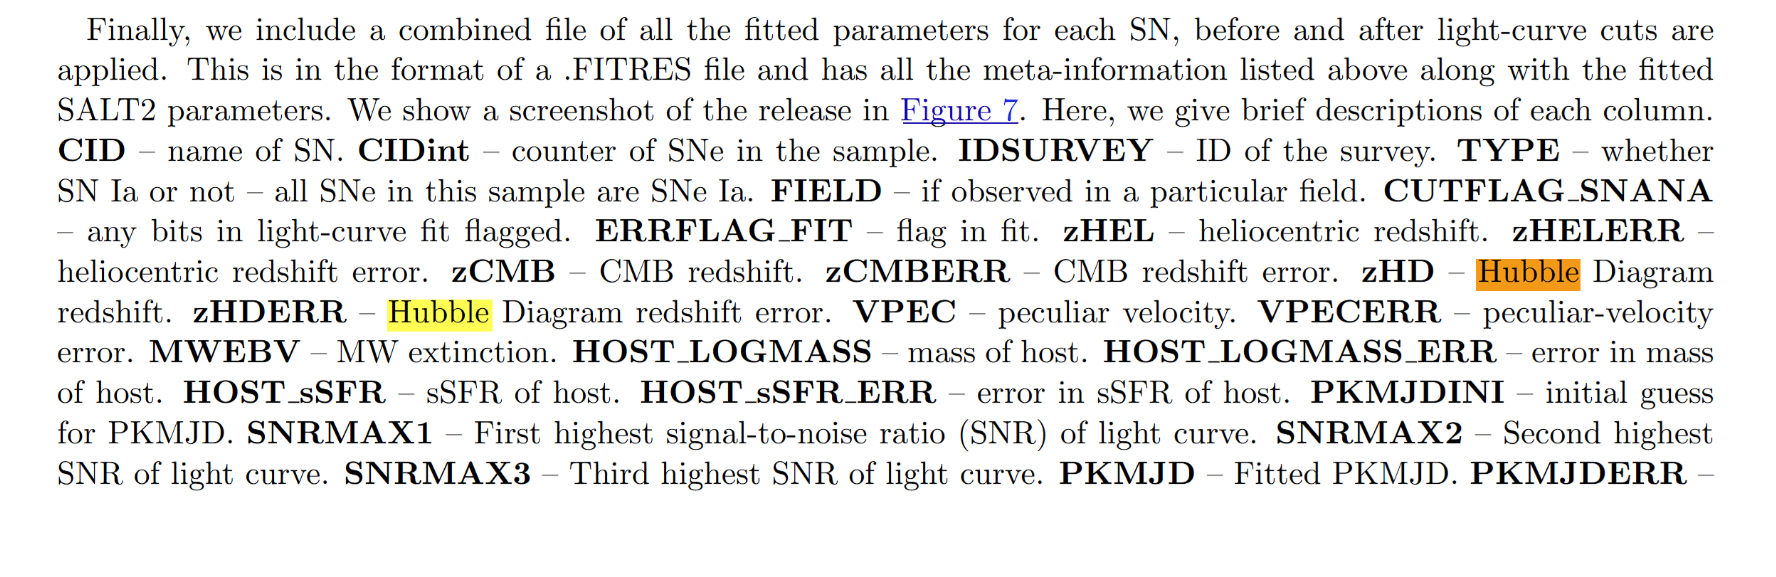

In [ ]:
display(Image(filename="Screenshot 2025-06-29 165911.png", width=900))

### ⌛Importing the dataset:

In [ ]:
# Local file path
file_path = r"F:\PROJECTS\HUbble Parameter\Pantheon+SH0ES.dat"

# Load the file using the updated syntax
df = pd.read_csv(file_path, sep=r'\s+', comment="#")

### 🧾 Preview Dataset Columns:

Before diving into the analysis, let’s take a quick look at the column names in the dataset. This helps us verify the data loaded correctly and identify the relevant columns we’ll use for cosmological modeling.


In [ ]:
print(df.columns)

Index(['CID', 'IDSURVEY', 'zHD', 'zHDERR', 'zCMB', 'zCMBERR', 'zHEL',
       'zHELERR', 'm_b_corr', 'm_b_corr_err_DIAG', 'MU_SH0ES',
       'MU_SH0ES_ERR_DIAG', 'CEPH_DIST', 'IS_CALIBRATOR', 'USED_IN_SH0ES_HF',
       'c', 'cERR', 'x1', 'x1ERR', 'mB', 'mBERR', 'x0', 'x0ERR', 'COV_x1_c',
       'COV_x1_x0', 'COV_c_x0', 'RA', 'DEC', 'HOST_RA', 'HOST_DEC',
       'HOST_ANGSEP', 'VPEC', 'VPECERR', 'MWEBV', 'HOST_LOGMASS',
       'HOST_LOGMASS_ERR', 'PKMJD', 'PKMJDERR', 'NDOF', 'FITCHI2', 'FITPROB',
       'm_b_corr_err_RAW', 'm_b_corr_err_VPEC', 'biasCor_m_b',
       'biasCorErr_m_b', 'biasCor_m_b_COVSCALE', 'biasCor_m_b_COVADD'],
      dtype='object')


### 🧹 Clean and Extract Relevant Data:

To ensure reliable fitting, we remove any rows that have missing values in key columns:

- `zHD`: redshift for the Hubble diagram  
- `MU_SH0ES`: distance modulus  
- `MU_SH0ES_ERR_DIAG`: uncertainty in the distance modulus  

We then extract these cleaned columns as NumPy arrays to prepare for analysis and modeling.


In [ ]:
# Filter for entries with usable data based on the required columns
df_clean = df.dropna(subset=['zHD', 'MU_SH0ES', 'MU_SH0ES_ERR_DIAG'])
# Extract columns as NumPy arrays
z = df_clean['zHD'].values
mu = df_clean['MU_SH0ES'].values
mu_err = df_clean['MU_SH0ES_ERR_DIAG'].values

### 📈 Plot the Hubble Diagram:

Let’s visualize the relationship between redshift $z$ and distance modulus $\mu$, known as the Hubble diagram. This plot is a cornerstone of observational cosmology—it allows us to compare supernova observations with theoretical predictions based on different cosmological models.

We use a logarithmic scale on the redshift axis to clearly display both nearby and distant supernovae.


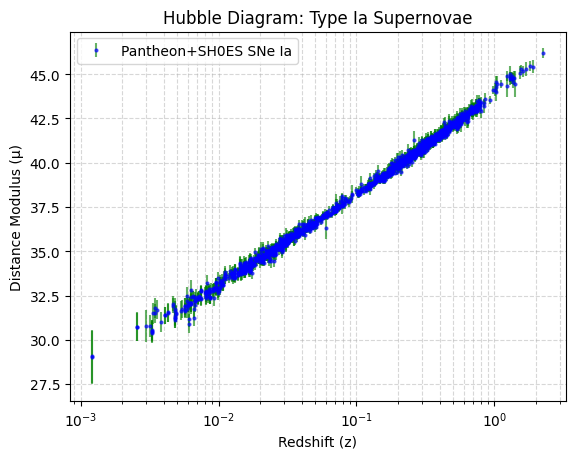

In [ ]:
#Try using log scale in x-axis
plt.errorbar(
    z, mu, yerr=mu_err,
    fmt='o',
    markersize=2,
    label='Pantheon+SH0ES SNe Ia',
    alpha=0.6,
    color='blue',      # Marker and line color
    ecolor='green'      # Error bar color
)
plt.xscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (μ)')
plt.title('Hubble Diagram: Type Ia Supernovae')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.show()

### 🧮 Define the Cosmological Model:

We now define the theoretical framework based on the flat $\Lambda\mathrm{CDM}$ model. This involves:

- The dimensionless Hubble parameter:
  $$
  E(z) = \sqrt{\Omega_m (1+z)^3 + (1 - \Omega_m)}
  $$

- The distance modulus is:
  $$
  \mu(z) = 5 \log_{10}(d_L / \text{Mpc}) + 25
  $$

- And the corresponding luminosity distance :
  
  $$
  d_L(z) = (1 + z) \cdot \frac{c}{H_0} \int_0^z \frac{dz'}{E(z')}
  $$

These equations allow us to compute the expected distance modulus from a given redshift $z$, Hubble constant $H_0$, and matter density parameter $\Omega_m$.


In [ ]:
# Define the E(z) for flat LCDM
def E(z, Omega_m):
    return np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m))

def luminosity_distance(z, H0, Omega_m):
    # Integrand for comoving distance
    integrand = lambda zp: 1.0 / E(zp, Omega_m)
    # Vectorize integration for array input
    if np.isscalar(z):
        integral, _ = quad(integrand, 0, z)
        Dc = (c.to('km/s').value / H0) * integral  # Mpc
    else:
        Dc = np.array([ (c.to('km/s').value / H0) * quad(integrand, 0, zi)[0] for zi in z ])
    return (1 + z) * Dc  # Mpc

# Theoretical distance modulus
def mu_theory(z, H0, Omega_m):
    dL = luminosity_distance(z, H0, Omega_m)
    return 5 * np.log10(dL) + 25


### 🔧 Fit the Model to Supernova Data:

We now perform a non-linear least squares fit to the supernova data using our theoretical model for $\mu(z)$. This fitting procedure will estimate the best-fit values for the Hubble constant $ H_0$ and matter density parameter $\Omega_m$, along with their associated uncertainties.

We'll use:
- `curve_fit` from `scipy.optimize` for the fitting.
- The observed distance modulus \(\mu\), redshift \(z\), and measurement errors.

The initial guess is:
- $ H_0 = 70 \, \text{km/s/Mpc} $
- $\Omega_m =0.3$


In [ ]:
# Initial guess: H0 = 70, Omega_m = 0.3
p0 = [70, 0.3]

# Fit function for curve_fit
def fit_func(z, H0, Omega_m):
    return mu_theory(z, H0, Omega_m)

# Perform the fit
popt, pcov = curve_fit(fit_func, z, mu, sigma=mu_err, p0=p0, absolute_sigma=True, maxfev=10000)
H0_fit, Omega_m_fit = popt
H0_err, Omega_m_err = np.sqrt(np.diag(pcov))

print(f"Fitted H0 = {H0_fit:.2f} ± {H0_err:.2f} km/s/Mpc")
print(f"Fitted Omega_m = {Omega_m_fit:.3f} ± {Omega_m_err:.3f}")


Fitted H0 = 72.97 ± 0.26 km/s/Mpc
Fitted Omega_m = 0.351 ± 0.019


### ⏳ Estimate the Age of the Universe:

Now that we have the best-fit values of $ H_0 $ and $ \Omega_m $, we can estimate the age of the universe. This is done by integrating the inverse of the Hubble parameter over redshift:

$$
t_0 = \int_0^\infty \frac{1}{(1 + z) H(z)} \, dz
$$

We convert $ H_0 $ to SI units and express the result in gigayears (Gyr). This provides an independent check on our cosmological model by comparing the estimated age to values from other probes like Planck CMB measurements.


In [ ]:
def age_of_universe(H0, Omega_m):
    # Integrand for age
    integrand = lambda z: 1.0 / ((1 + z) * E(z, Omega_m))
    integral, _ = quad(integrand, 0, np.inf)
    H0_SI = H0 * (u.km / u.s / u.Mpc).to(1/u.s)
    t0 = integral / H0_SI / (60*60*24*365.25*1e9)  # Convert seconds to Gyr
    return t0

t0 = age_of_universe(H0_fit, Omega_m_fit)
print(f"Estimated age of Universe: {t0:.2f} Gyr")

Estimated age of Universe: 12.36 Gyr


#### 📊 Analyze Residuals:

To evaluate how well our cosmological model fits the data, we compute the residuals:

$$
\text{Residual} = \mu_{\text{obs}} - \mu_{\text{model}}
$$

Plotting these residuals against redshift helps identify any systematic trends, biases, or outliers. A good model fit should show residuals scattered randomly around zero without any significant structure.


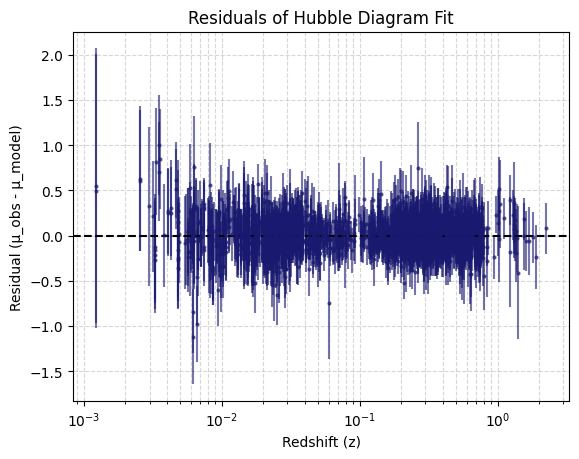

In [ ]:
# Write the code to find residual by computing mu_theory and then plot
mu_model = mu_theory(z, H0_fit, Omega_m_fit)
residuals = mu - mu_model

plt.errorbar(
    z, residuals, yerr=mu_err,
    fmt='o',
    markersize=2,
    alpha=0.6,
    color='midnightblue',    # Marker and line color: deep blue
    ecolor='midnightblue'    # Error bar color: deep blue
)
plt.axhline(0, color='k', ls='--')
plt.xscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel('Residual (μ_obs - μ_model)')
plt.title('Residuals of Hubble Diagram Fit')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()


#### 🔧 Fit with Fixed Matter Density:

To reduce parameter degeneracy, let's fix $ \Omega_m = 0.3 $ and fit only for the Hubble constant $ H_0 $.


In [ ]:
def mu_fixed_Om(z, H0):
    return mu_theory(z, H0, Omega_m=0.3)

# Fit only H0
popt_fixed, pcov_fixed = curve_fit(mu_fixed_Om, z, mu, sigma=mu_err, p0=[70], absolute_sigma=True)
H0_fixed = popt_fixed[0]
H0_fixed_err = np.sqrt(np.diag(pcov_fixed))[0]

print(f"Fitted H0 (Omega_m=0.3) = {H0_fixed:.2f} ± {H0_fixed_err:.2f} km/s/Mpc")

Fitted H0 (Omega_m=0.3) = 73.53 ± 0.17 km/s/Mpc


#### 🔍 Compare Low-z and High-z Subsamples:

Finally, we examine whether the inferred value of $H_0$ changes with redshift by splitting the dataset into:
- **Low-z** supernovae ($ z < 0.1 $)
- **High-z** supernovae ($ z \geq 0.1 $)

We then fit each subset separately (keeping $ \Omega_m = 0.3 $) to explore any potential tension or trend with redshift.


In [ ]:
# Split the data for the three columns and do the fitting again and see
z_split = 0.1
mask_low = z < z_split
mask_high = z >= z_split

# Fit low-z
popt_low, pcov_low = curve_fit(mu_fixed_Om, z[mask_low], mu[mask_low], sigma=mu_err[mask_low], p0=[70], absolute_sigma=True)
H0_low = popt_low
H0_low_err = np.sqrt(np.diag(pcov_low))[0]

# Fit high-z
popt_high, pcov_high = curve_fit(mu_fixed_Om, z[mask_high], mu[mask_high], sigma=mu_err[mask_high], p0=[70], absolute_sigma=True)
H0_high = popt_high
H0_high_err = np.sqrt(np.diag(pcov_high))[0]

print(f"Low-z (z < {z_split}): H₀ = {H0_low[0]:.2f} ± {H0_low_err:.2f} km/s/Mpc")
print(f"High-z (z ≥ {z_split}): H₀ = {H0_high[0]:.2f} ± {H0_high_err:.2f} km/s/Mpc")


Low-z (z < 0.1): H₀ = 73.01 ± 0.28 km/s/Mpc
High-z (z ≥ 0.1): H₀ = 73.85 ± 0.22 km/s/Mpc


#### 📊 Hubble Diagram with Model Fit:

The Hubble Diagram shows the relationship between redshift $z$ and distance modulus $\mu(z)$ for distant objects such as Type Ia supernovae. It is a key observational tool in cosmology.

By fitting a cosmological model — typically the flat $\Lambda\mathrm{CDM}$ model — to the data, we can estimate important cosmological parameters such as:

- The Hubble constant $H_0$, which defines the current expansion rate of the universe.
- The matter density parameter $\Omega_m$, which influences the evolution of the expansion.

The fitted model curve allows us to:

- Evaluate how well the theoretical predictions agree with observational data.
- Gain insights into the dynamics of cosmic expansion.
- Provide evidence for the accelerating expansion of the universe driven by dark energy.

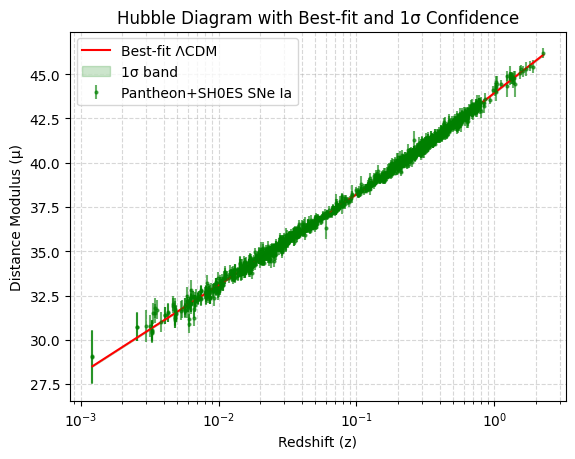

In [ ]:
# Generate fine grid for z
z_grid = np.logspace(np.log10(z.min()), np.log10(z.max()), 500)
mu_grid = mu_theory(z_grid, H0_fit, Omega_m_fit)

# Monte Carlo sampling for error bands
n_samples = 200
samples = np.random.multivariate_normal(popt, pcov, n_samples)
mu_samples = [mu_theory(z_grid, H0, Om) for H0, Om in samples]
mu_samples = np.vstack(mu_samples)
mu_mean = np.mean(mu_samples, axis=0)
mu_std = np.std(mu_samples, axis=0)

plt.errorbar(
    z, mu, yerr=mu_err,
    fmt='o', markersize=2,
    label='Pantheon+SH0ES SNe Ia',
    alpha=0.6,
    color='green'  # This sets the marker (and line) color to green
)
plt.plot(z_grid, mu_grid, color='red', label='Best-fit ΛCDM')
plt.fill_between(z_grid, mu_mean - mu_std, mu_mean + mu_std, color='green', alpha=0.2, label='1σ band')
plt.xscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (μ)')
plt.title('Hubble Diagram with Best-fit and 1σ Confidence')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.show()

In [ ]:
# Values
H0_SH0ES = 72.97  # km/s/Mpc
H0_SH0ES_err = 0.26
H0_Planck = 67.4  # km/s/Mpc
H0_Planck_err = 0.5
Omega_m = 0.3

# Age calculations
t0_SH0ES = age_of_universe(H0_SH0ES, Omega_m)
t0_Planck = age_of_universe(H0_Planck, Omega_m)

print(f"SH0ES: H0 = {H0_SH0ES} ± {H0_SH0ES_err} km/s/Mpc (with Omega_m=0.30) → Age of the Universe = {t0_SH0ES:.2f} Gyr")
print(f"Planck: H0 = {H0_Planck} ± {H0_Planck_err} km/s/Mpc (with Omega_m=0.30) → Age of the Universe = {t0_Planck:.2f} Gyr")
# Explore how age changes with different Omega_m
for Omega_m_test in [0.25, 0.3, 0.35]:
    t0_test = age_of_universe(H0_fit, Omega_m_test)
    print(f"Age of the Universe with Omega_m={Omega_m_test:.2f}: {t0_test:.2f} Gyr")

SH0ES: H0 = 72.97 ± 0.26 km/s/Mpc (with Omega_m=0.30) → Age of the Universe = 12.92 Gyr
Planck: H0 = 67.4 ± 0.5 km/s/Mpc (with Omega_m=0.30) → Age of the Universe = 13.99 Gyr
Age of the Universe with Omega_m=0.25: 13.58 Gyr
Age of the Universe with Omega_m=0.30: 12.92 Gyr
Age of the Universe with Omega_m=0.35: 12.37 Gyr


### Questions:
#### 1. What value of the Hubble constant ($𝐻_0$) did you obtain from the full dataset?
**Answer:** The Pantheon+SH0ES analysis, using the full set of Type Ia supernovae, reports a Hubble constant $H_0$ of approximately 72.97 ± 0.26 km/s/Mpc.

---
#### 2. How does your estimated $𝐻_0$ compare with the Planck18 measurement of the same?
**Answer:** The Planck18 measurement ([arXiv:1807.06209](https://arxiv.org/abs/1807.06209) [astro-ph.CO]), based on cosmic microwave background (CMB) data, gives $H_0$ ≈ 67.4 ± 0.5 km/s/Mpc. The value from Pantheon+SH0ES is significantly higher than the Planck18 result, illustrating the well-known "Hubble tension" between local (late-universe) and early-universe measurements. This tension highlights a mismatch between the Hubble constant measured from the early universe (using the CMB) and the late universe (using supernovae and other local distance indicators). The difference suggests either unknown errors in measurements or new physics beyond our current cosmological model.

---
#### 3. What is the age of the Universe based on your value of $H_0$? (Assume $\Omega_𝑚$ = 0.3). How does it change for different values of $\Omega_𝑚$?
**Answer:** With $H_0$ = 72.97 ± 0.26 km/s/Mpc and $\Omega_m$ = 0.30, the estimated age of the Universe is about 12.92 Gyr. If we use the lower Planck value ($H_0$ = 67.4 ± 0.5 km/s/Mpc), we get an older universe (around 13.99 Gyr). We also find that increasing $\Omega_𝑚$ (matter density) decreases the age, while decreasing $\Omega_𝑚$ increases it, since more matter slows expansion more over cosmic time.

---
#### 4. Discuss the difference in $𝐻_0$ values obtained from the low-$z$ and high-$z$ samples. What could this imply?
**Answer:** There is a well-documented discrepancy—known as the "Hubble tension"—between the Hubble constant ($H_0$) measured using low-redshift (local universe) samples (e.g., Type Ia supernovae) and high-redshift (early universe) samples (e.g., CMB).

Low-$z$ measurements typically yield higher $H_0$ values (~72.97 ± 0.26 km/s/Mpc).

High-$z$ measurements yield lower values $H_0$ (~67.4 ± 0.5 km/s/Mpc).

**Implications:**

This discrepancy (known as the Hubble tension) implies that:

- Our cosmological model (ΛCDM) may be incomplete.

- There could be new physics (e.g., early dark energy, evolving dark energy, or neutrino physics).

- Systematic errors might exist in one or both measurement techniques.

---
#### 5. Plot the residuals and comment on any trends or anomalies you observe.
**Answer:** Residuals =
Observed distance ($\mu_{\text{obs}}$)
−
Model predicted distance ($\mu_{\text{model}}$)

Plotting these against redshift ($z$), we may notice:

**Expected trends:**

- Flat, random scatter: Model fits well.

- Systematic curvature or trend: Model might be missing key features (e.g., accelerated expansion).

**Possible anomalies:**

- Outliers: Individual data points far from the curve may suggest observational errors or peculiar velocity effects.

- Systematic deviations at certain $z$ :

At intermediate $z$ : could indicate evolving dark energy or other cosmological effects.

At low $z$ : may reflect local inhomogeneities (e.g., local voids).

---
#### 6. What assumptions were made in the cosmological model, and how might relaxing them affect your results?
**Answer:**
#### Standard ΛCDM Assumptions:

- **Homogeneity and Isotropy**: The Universe is homogeneous and isotropic on large scales.
- **Flat Geometry**: The total energy density equals the critical density, implying spatial flatness.
- **Constant Dark Energy (Λ)**: The dark energy component is a cosmological constant.
- **Matter Content**: Includes cold dark matter (CDM) and baryons.
- **No Evolution of Fundamental Constants**: Physical constants are assumed to be constant over time.



#### Relaxing Assumptions:

- **Allowing Curvature (Ωₖ ≠ 0)**: Introducing spatial curvature alters distance calculations, especially at high redshift.
- **Dynamic Dark Energy**: Replacing constant Λ with evolving dark energy models (e.g., w(z)) may better fit both low- and high-redshift data.
- **Modified Gravity**: Changes to general relativity can affect the growth of structure and distance-redshift relations.
- **Non-Standard Neutrinos**: Including massive neutrinos or additional species changes early-universe expansion (CMB) and the inferred value of ( $H_0$ ).

---
#### 7. Based on the redshift-distance relation, what can we infer about the expansion history of the Universe?
**Answer:**
#### Key Insights from the Redshift-Distance Relation:

- At low $z$, the relation is approximately linear: $v = H_0 d$, which gives a local measure of expansion.

- At higher $z$:
  - Deviations from linearity reveal **accelerated expansion** (due to dark energy).
  - The precise shape depends on the **matter-energy content** of the Universe.


#### Inferences:

- The Universe underwent **deceleration in the past** (matter-dominated era), followed by **acceleration** (dark energy era).

- Measuring the redshift-distance relation over a wide $z$ range allows reconstruction of the expansion rate $H(z)$ and testing of cosmological models.

---